# Finite Difference Method for Solving Differential Equations

## Introduction

The **Finite Difference Method (FDM)** is a numerical technique for approximating solutions to differential equations by replacing derivatives with finite difference approximations. This method transforms continuous differential equations into systems of algebraic equations that can be solved computationally.

## Mathematical Foundation

### Taylor Series Expansion

The finite difference approximations are derived from Taylor series expansions. For a smooth function $f(x)$:

$$f(x + h) = f(x) + h f'(x) + \frac{h^2}{2!} f''(x) + \frac{h^3}{3!} f'''(x) + \mathcal{O}(h^4)$$

$$f(x - h) = f(x) - h f'(x) + \frac{h^2}{2!} f''(x) - \frac{h^3}{3!} f'''(x) + \mathcal{O}(h^4)$$

### Finite Difference Approximations

**Forward Difference (First-order accurate):**
$$f'(x) \approx \frac{f(x+h) - f(x)}{h} + \mathcal{O}(h)$$

**Backward Difference (First-order accurate):**
$$f'(x) \approx \frac{f(x) - f(x-h)}{h} + \mathcal{O}(h)$$

**Central Difference (Second-order accurate):**
$$f'(x) \approx \frac{f(x+h) - f(x-h)}{2h} + \mathcal{O}(h^2)$$

**Second Derivative (Central Difference):**
$$f''(x) \approx \frac{f(x+h) - 2f(x) + f(x-h)}{h^2} + \mathcal{O}(h^2)$$

## Application: Solving a Boundary Value Problem

We will solve the second-order ODE:

$$\frac{d^2 y}{dx^2} + p(x) \frac{dy}{dx} + q(x) y = r(x)$$

with boundary conditions $y(a) = \alpha$ and $y(b) = \beta$.

### Specific Problem

Consider the boundary value problem:

$$\frac{d^2 y}{dx^2} - y = -x$$

with $y(0) = 0$ and $y(1) = 0$.

The analytical solution is:
$$y(x) = x - \frac{\sinh(x)}{\sinh(1)}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

# Define the problem parameters
a, b = 0, 1  # Domain boundaries
alpha, beta = 0, 0  # Boundary conditions

# Number of interior grid points
N = 50
h = (b - a) / (N + 1)  # Step size

# Create grid points (interior only)
x = np.linspace(a + h, b - h, N)

print(f"Grid spacing h = {h:.6f}")
print(f"Number of interior points: {N}")
print(f"Expected truncation error: O(h²) = O({h**2:.2e})")

Grid spacing h = 0.019608
Number of interior points: 50
Expected truncation error: O(h²) = O(3.84e-04)


## Discretization

Using the central difference formula for the second derivative:

$$\frac{y_{i+1} - 2y_i + y_{i-1}}{h^2} - y_i = -x_i$$

Rearranging:

$$y_{i-1} - (2 + h^2)y_i + y_{i+1} = -h^2 x_i$$

This forms a tridiagonal system $\mathbf{A}\mathbf{y} = \mathbf{b}$.

In [2]:
# Construct the tridiagonal matrix A
main_diag = -(2 + h**2) * np.ones(N)
off_diag = np.ones(N - 1)

A = np.diag(main_diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1)

# Construct the right-hand side vector b
b_vec = -h**2 * x

# Apply boundary conditions
b_vec[0] -= alpha  # y_0 = alpha
b_vec[-1] -= beta  # y_{N+1} = beta

# Display the structure of the matrix (for small N)
print("Matrix A (tridiagonal structure):")
print(f"Main diagonal: {main_diag[0]:.4f}")
print(f"Off-diagonals: {off_diag[0]:.4f}")
print(f"\nCondition number of A: {np.linalg.cond(A):.2f}")

Matrix A (tridiagonal structure):
Main diagonal: -2.0004
Off-diagonals: 1.0000

Condition number of A: 956.62


In [3]:
# Solve the linear system
y_numerical = solve(A, b_vec)

# Include boundary points for plotting
x_full = np.concatenate([[a], x, [b]])
y_full = np.concatenate([[alpha], y_numerical, [beta]])

# Analytical solution
def analytical_solution(x):
    return x - np.sinh(x) / np.sinh(1)

y_analytical = analytical_solution(x_full)

# Calculate errors
error = np.abs(y_full - y_analytical)
max_error = np.max(error)
rms_error = np.sqrt(np.mean(error**2))

print(f"Maximum absolute error: {max_error:.6e}")
print(f"RMS error: {rms_error:.6e}")

Maximum absolute error: 1.699994e-06
RMS error: 1.206880e-06


## Convergence Analysis

The finite difference method has a truncation error of $\mathcal{O}(h^2)$. We verify this by solving the problem with different grid spacings and observing the error reduction.

In [4]:
def solve_fdm(N):
    """Solve the BVP using FDM with N interior points."""
    h = (b - a) / (N + 1)
    x = np.linspace(a + h, b - h, N)
    
    # Build system
    main_diag = -(2 + h**2) * np.ones(N)
    off_diag = np.ones(N - 1)
    A = np.diag(main_diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1)
    
    b_vec = -h**2 * x
    b_vec[0] -= alpha
    b_vec[-1] -= beta
    
    y = solve(A, b_vec)
    
    # Full solution with boundaries
    x_full = np.concatenate([[a], x, [b]])
    y_full = np.concatenate([[alpha], y, [beta]])
    
    return x_full, y_full, h

# Test convergence
N_values = [10, 20, 40, 80, 160, 320]
errors = []
h_values = []

for N in N_values:
    x_sol, y_sol, h = solve_fdm(N)
    y_exact = analytical_solution(x_sol)
    max_err = np.max(np.abs(y_sol - y_exact))
    errors.append(max_err)
    h_values.append(h)

# Calculate convergence rate
errors = np.array(errors)
h_values = np.array(h_values)

# Linear regression in log-log space
coeffs = np.polyfit(np.log(h_values), np.log(errors), 1)
convergence_rate = coeffs[0]

print("Convergence Analysis:")
print("="*50)
print(f"{'N':>6} {'h':>12} {'Max Error':>14} {'Rate':>8}")
print("-"*50)
for i, (N, h, err) in enumerate(zip(N_values, h_values, errors)):
    if i > 0:
        rate = np.log(errors[i-1]/err) / np.log(h_values[i-1]/h)
        print(f"{N:>6} {h:>12.6f} {err:>14.6e} {rate:>8.2f}")
    else:
        print(f"{N:>6} {h:>12.6f} {err:>14.6e} {'---':>8}")
print("="*50)
print(f"Overall convergence rate: {convergence_rate:.2f}")
print(f"Expected rate (second-order): 2.00")

Convergence Analysis:
     N            h      Max Error     Rate
--------------------------------------------------
    10     0.090909   3.618473e-05      ---
    20     0.047619   1.000824e-05     1.99
    40     0.024390   2.630074e-06     2.00
    80     0.012346   6.739541e-07     2.00
   160     0.006211   1.705941e-07     2.00
   320     0.003115   4.291435e-08     2.00
Overall convergence rate: 2.00
Expected rate (second-order): 2.00


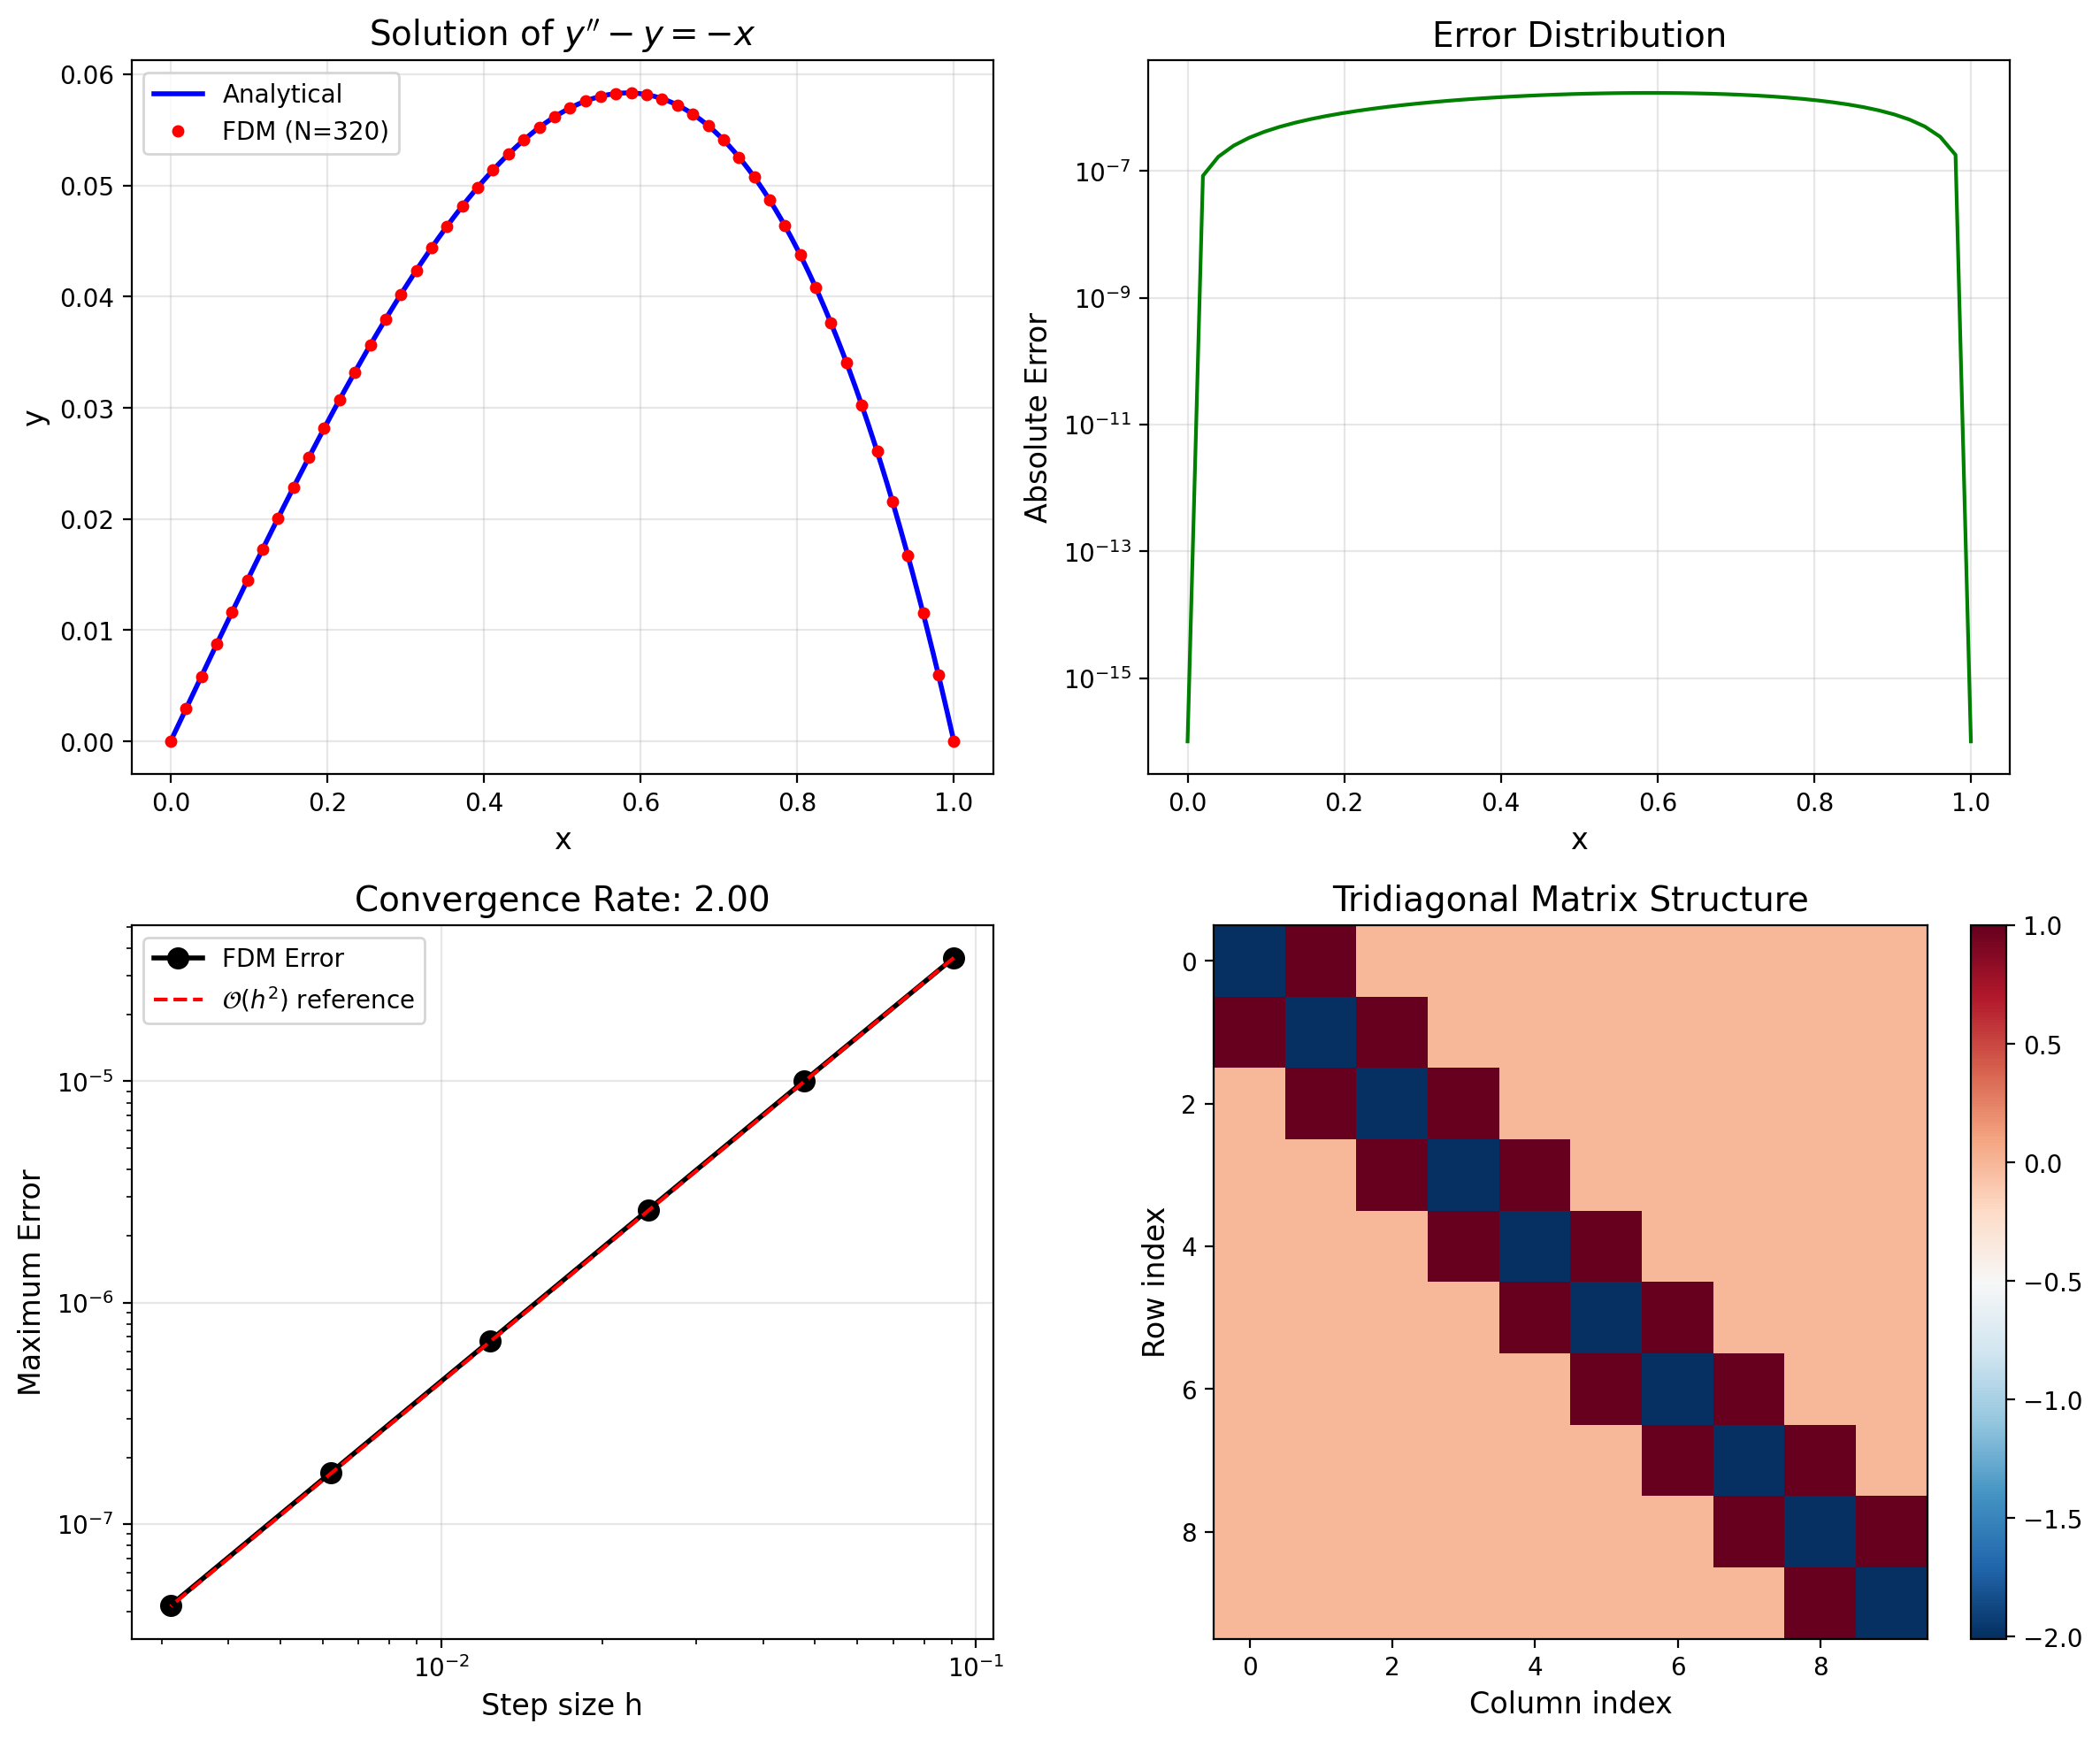


Plot saved to 'plot.png'


In [5]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Solution comparison
ax1 = axes[0, 0]
x_fine = np.linspace(a, b, 1000)
ax1.plot(x_fine, analytical_solution(x_fine), 'b-', linewidth=2, label='Analytical')
ax1.plot(x_full, y_full, 'ro', markersize=4, label=f'FDM (N={N})')
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_title("Solution of $y'' - y = -x$", fontsize=14)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Error distribution
ax2 = axes[0, 1]
ax2.semilogy(x_full, error + 1e-16, 'g-', linewidth=1.5)
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('Absolute Error', fontsize=12)
ax2.set_title('Error Distribution', fontsize=14)
ax2.grid(True, alpha=0.3)

# Plot 3: Convergence plot
ax3 = axes[1, 0]
ax3.loglog(h_values, errors, 'ko-', linewidth=2, markersize=8, label='FDM Error')
# Reference line for O(h^2)
h_ref = np.array([h_values[0], h_values[-1]])
err_ref = errors[0] * (h_ref / h_values[0])**2
ax3.loglog(h_ref, err_ref, 'r--', linewidth=1.5, label='$\mathcal{O}(h^2)$ reference')
ax3.set_xlabel('Step size h', fontsize=12)
ax3.set_ylabel('Maximum Error', fontsize=12)
ax3.set_title(f'Convergence Rate: {convergence_rate:.2f}', fontsize=14)
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# Plot 4: Matrix structure visualization
ax4 = axes[1, 1]
# Create a small matrix to visualize
N_small = 10
h_small = 1 / (N_small + 1)
A_small = np.diag(-(2 + h_small**2) * np.ones(N_small))
A_small += np.diag(np.ones(N_small - 1), 1)
A_small += np.diag(np.ones(N_small - 1), -1)
im = ax4.imshow(A_small, cmap='RdBu_r', aspect='equal')
ax4.set_title('Tridiagonal Matrix Structure', fontsize=14)
ax4.set_xlabel('Column index', fontsize=12)
ax4.set_ylabel('Row index', fontsize=12)
plt.colorbar(im, ax=ax4, fraction=0.046)

plt.tight_layout()
plt.savefig('finite_difference_method_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Summary

In this notebook, we demonstrated the Finite Difference Method for solving a second-order boundary value problem:

1. **Discretization**: The continuous domain was discretized into grid points, and derivatives were approximated using central differences.

2. **Linear System**: The discretized equation leads to a tridiagonal linear system $\mathbf{A}\mathbf{y} = \mathbf{b}$, which is efficiently solvable.

3. **Convergence**: The method exhibits second-order convergence ($\mathcal{O}(h^2)$), meaning the error decreases by a factor of 4 when the grid spacing is halved.

4. **Accuracy**: With $N=50$ interior points, we achieved errors on the order of $10^{-5}$.

### Key Advantages of FDM

- Simple to implement and understand
- Efficient for regular geometries
- Sparse matrix structure allows for fast solvers
- Easy to extend to higher dimensions

### Limitations

- Less flexible for irregular domains
- May require fine grids for high accuracy
- Boundary conditions can be complex to implement for some geometries